In [1]:
import multinet_lib

import pathlib
import pandas as pd
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import henhoe2vec as hh2v
import ast
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt


#from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#Modelling
from sklearn.mixture import GaussianMixture
import sklearn
from copy import deepcopy


#OT
import ot
from gmmot import *


/home/kuehn/anaconda3/envs/mamba/envs/GMM2OT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot2D_embeddings(path,true_blocks,save=False):
    df = pd.read_csv(path.parent / (path.name + '.csv'), sep="\t", index_col=0, header=None)

    df_embed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(df.values)
    df_embed = pd.DataFrame(df_embed,columns=['x','y'])

    df_embed.index = [ast.literal_eval(tpl) for tpl in df.index]
    df_embed["node"],df_embed["layer"] = zip(*df_embed.index.tolist())

    node_to_block = [block for block in range(len(true_blocks)) for _ in range(true_blocks[block])]
    df_embed['block'] = [node_to_block[int(float(node))] for node in df_embed['node']]

    

    
    plt.figure()
    ax = sns.scatterplot(df_embed,x='x',y='y',hue='block',style='layer',palette="deep") #,ax=axs[i])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()

    if save:
        plt.savefig(path.parent / (path.name + '.png'))

    plt.show()

    return df.values,df_embed


def block_mixing_over_layers(layers,blocks,mixing_chance):
    ml_blocks=[]
    n_blocks= len(blocks)
    for l in range(layers):
        #Mix blocks on layer depending on block_mixing_chance
        mixed_blocks=np.copy(blocks)
        for i in range(n_blocks-1):
            if np.random.rand()<mixing_chance:
                mixed_blocks[i+1] += mixed_blocks[i] 
                mixed_blocks[i] = 0  
        ml_blocks.append(mixed_blocks)
    return np.asarray(ml_blocks,dtype=int)

def fit_GMM(pts,n_components,title=None, ax=None):

    nsamples, _  = pts.shape
    flat_pts = pts.reshape((nsamples,-1))

    gmm = GaussianMixture(n_components=n_components, random_state=0).fit(flat_pts )
    #plot_ellipses(gmm,pts,title=title,ax=ax)
    return gmm

In [3]:
#Outputs
path = pathlib.Path().resolve()
save_path = path / "resources"

#SBM params
inner_connectivity = 0.5
outer_connectivity = 0.05
layers = 3
SBM_samples = 1

#Create true blocks and mix them over layers
true_blocks =  [[25,25,25,25,25,25]] #,np.random.randint(100,size=(10)),np.random.randint(150,size=(7)),np.random.randint(100,size=(10))]
mixed_blocks =  [block_mixing_over_layers(layers,true_block,0.4) for true_block in true_blocks] #np.asarray([[50,50,150],[150,50,50],[50,150,50]]) #
print(mixed_blocks)
mixed_blocks =  [np.asarray([[10,10,5,5],[10,5,5,10],[5,5,10,10]]) * 5]  # #
print(mixed_blocks)

[array([[25,  0, 50, 25,  0, 50],
       [25,  0, 50, 25, 25, 25],
       [25, 25, 25,  0, 50, 25]])]
[array([[50, 50, 25, 25],
       [50, 25, 25, 50],
       [25, 25, 50, 50]])]


(50, 2)
(50, 2)
(25, 2)
(25, 2)
(50, 2)
(25, 2)
(25, 2)
(50, 2)
(25, 2)
(25, 2)
(50, 2)
(50, 2)
[[6.92014262e-310 1.00000000e+000 1.58496250e+000 ... 1.00000000e+000
  1.00000000e+000 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 2.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.00000000e+000]
 [1.58496250e+000 2.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  1.00000000e+000 0.00000000e+000]
 ...
 [1.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 0.00000000e+000 1.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.58496250e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.00000000e+000
  1.58496250e+000 0.00000000e+000]]
            x         y  block  layer
0    0.974434  0.435859      0      0
1    0.888671  0.346777      0      0
2    1.043215  0.466349      0      0
3    0.871708  0.458026      0      0
4    0.839191  0.411248      0      0
..        ...       ...    ...    ...
44

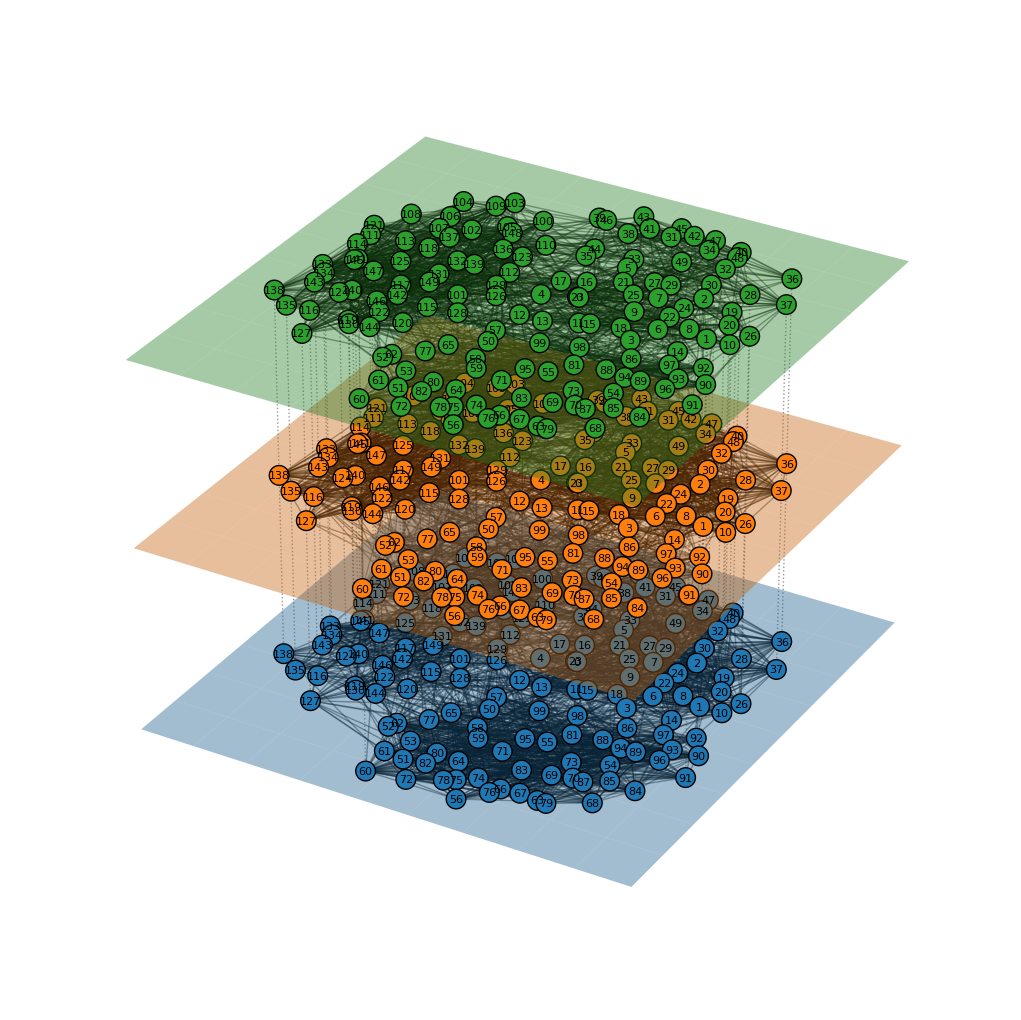

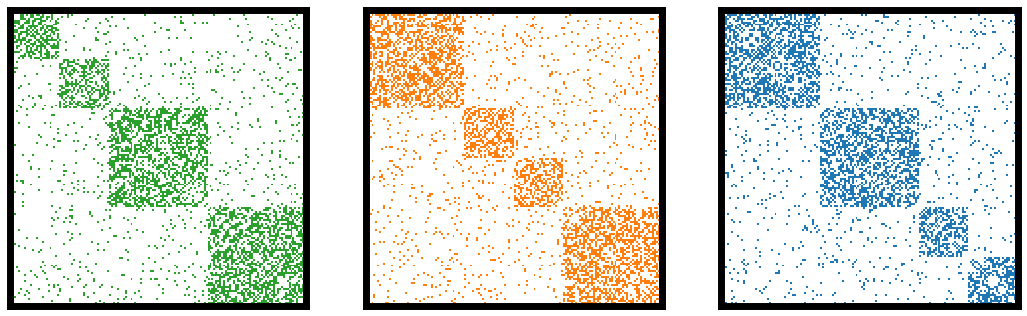

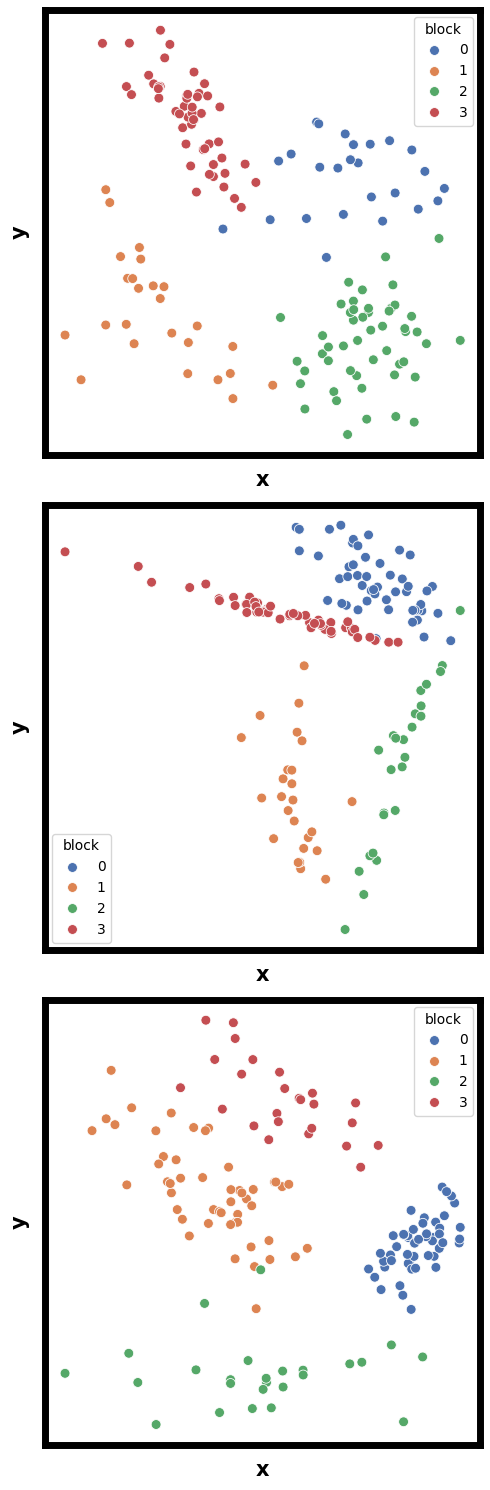

[[0.02851215 0.15188189 0.11651692 ... 0.01642068 0.         0.        ]
 [0.02833203 0.15010878 0.11546433 ... 0.03299042 0.01649521 0.01649521]
 [0.03383812 0.17866264 0.1372645  ... 0.01412387 0.         0.01412387]
 ...
 [0.0238609  0.16103872 0.01372182 ... 0.10130712 0.2431371  0.06078427]
 [0.02682467 0.21321169 0.01936354 ... 0.10439811 0.22619591 0.03479937]
 [0.02379576 0.17716823 0.01560332 ... 0.07963828 0.23891485 0.05972871]]
             x          y  node  layer
0   -35.879177  37.947544     0      0
1   -40.762009  43.171635     1      0
2   -57.218185  30.744434     2      0
3   -31.336250  41.488846     3      0
4   -56.628716  33.881264     4      0
..         ...        ...   ...    ...
445  57.463688 -24.924887   145      2
446  59.212429 -28.719265   146      2
447  56.698601 -13.045002   147      2
448  50.485920 -29.491070   148      2
449  55.732529 -14.014743   149      2

[450 rows x 4 columns]
            x         y  block  layer
0    0.974434  0.435859   

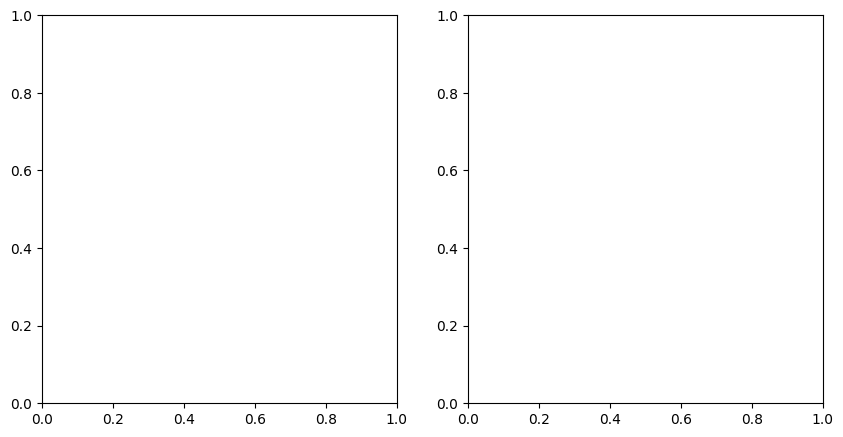

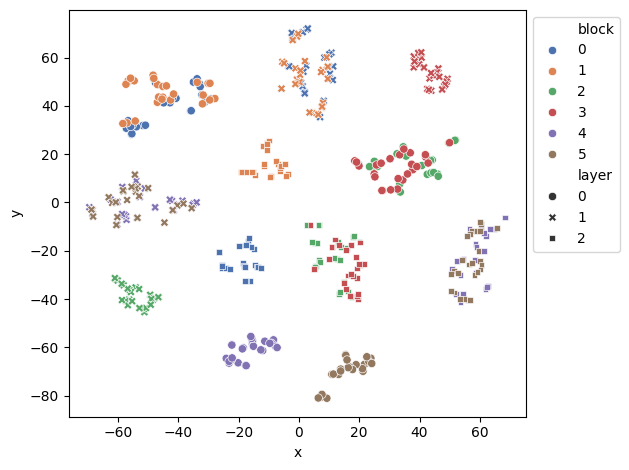

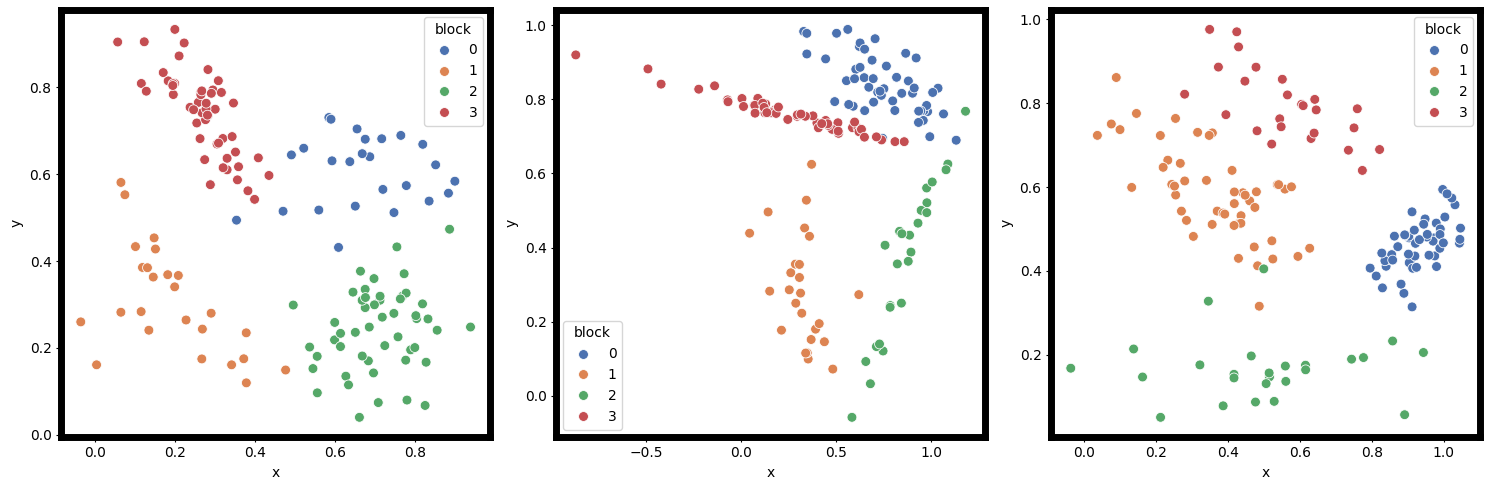

In [4]:
sampled_SBMs = {}
sampled_STR_pts = {}
sampled_GMMs_struct = {}
sampled_GMMs_attr = {}
sampled_GMMs_full = {}

for i,blocks in enumerate(mixed_blocks):
    for s in range(SBM_samples):
        id = f"SBM{i}_s{s}"
        print(blocks)
        #Sample from SBM according to mixed blocks
        sampled_SBMs[id] = multinet_lib.SBM_Multiplex(layers=layers,attributes=True,blocks=blocks,self_connectivity = inner_connectivity,outer_connectivity = outer_connectivity,plot=True)
        sampled_SBMs[id].plot_attributes(direction="vertical",example=True)

        #Compute high-dim strutural representation and plot 2D embedding of it
        average_block_size = float(np.sum(blocks) / (layers * len(blocks[0])))
        
        #HenHoe2Vec
        #sampled_SBMs[id].structural_embedding(save_path,f"{id}",ground_truth=true_blocks[i],q=1.0,s=1/average_block_size,num_walks=50)

        sampled_SBMs[id].structural_embedding(save_path,f"{id}",method="CCB",ground_truth=true_blocks[i],c=10,d=5,num_inits=100)


        #Fit Gaussian for Structures
        #sampled_GMMs_struct[id] = fit_GMM(sampled_SBMs[id].structural_embd_array,n_components=np.count_nonzero(mixed_blocks[i]))

        #Fit Gaussian for Attributes
        #sampled_GMMs_attr[id]= fit_GMM(sampled_SBMs[id].node_attributes,n_components=np.count_nonzero(mixed_blocks[i]))

        #sampled_GMMs_full[id] = sampled_SBMs[id].fit_GMM_over_struct_and_atr(n_components=np.count_nonzero(mixed_blocks[i]))

    

In [5]:

def GMM_wasserstein_dist(GMM0,GMM1):
    K0,d = GMM0.means_.shape #currently only for d1 = d2
    K1, _ = GMM1.means_.shape

    pi0=GMM0.weights_
    mu0=GMM0.means_
    S0=GMM0.covariances_

    pi1=GMM1.weights_
    mu1=GMM1.means_
    S1=GMM1.covariances_

    wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
    return dist


def pairwise_GMM_wasserstein_dist(GMMs):
    dist = np.zeros((len(GMMs),len(GMMs)))
    for i,gmm1 in enumerate(GMMs):
        for j,gmm2 in enumerate(GMMs):
            dist[i,j] = GMM_wasserstein_dist(gmm1,gmm2)


    sns.heatmap(dist) #,xticklabels=graph_iter_labels, yticklabels=graph_iter_labels,cmap="crest")

#roation/reflection invariant OT
def inner_GMM__wasserstein_dist(GMM, pts=None,shape_only=False):
    GMM = deepcopy(GMM)

    pi=GMM.weights_
    mu=GMM.means_
    S =GMM.covariances_
    
    #pts_of_comps = [[]] * len(S)

    
    #print(comp_of_pts)

    aligned_S = np.copy(GMM.covariances_)

    if shape_only:
        comp_of_pts = GMM.predict(pts)
        for component,(mu_,s) in enumerate(zip(mu,S)):   

            #pca = PCA()
            #pca.fit(pts[comp_of_pts==component]-mu_)

            _, _, Vt = np.linalg.svd(pts[comp_of_pts==component]-mu_)

            aligned_S[component]  = np.cov(((pts[comp_of_pts==component]-mu_)@ Vt).T)

            #plt.figure(component+2)
            #v , w = np.linalg.eigh(s)
            #plt.scatter(v,w)

            #plt.scatter(s[:, 0],s[:, 1])
            #plt.scatter(((pts[comp_of_pts==component]-mu_)@ Vt )[:, 0],((pts[comp_of_pts==component]-mu_)@ Vt)[:, 1])

            #aligned_S[component]  = ((s-mu_) @ Vt ) +mu_

            #
            #s = s.reshape(-1, 1) 
            #print(s)                   

            #aligned_S[component] = pca.get_covariance() # sorted_by_order # np.squeeze(pca.fit_transform(s))

            #print(aligned_S[component])

        GMM.covariances_=aligned_S

    #plot_ellipses(GMM, pts)
    #compute pairwise wassersteins dists between gaussians
    dist = np.zeros((len(mu),len(mu)))
    for i,(m0,S0) in enumerate(zip(mu,aligned_S)):
        for j,(m1,S1) in enumerate(zip(mu,aligned_S)):
            #print(S0)
            dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1) 
    return dist
    

def inner_pts_dist(pts, dist_measure=np.linalg.norm):
    dist = np.zeros((len(pts),len(pts)))
    for i, pt1 in enumerate(pts):
        for j, pt2 in enumerate(pts):
            dist[i,j] = dist_measure(pt1-pt2)
    return dist


In [6]:
#Unit based
inner_W_dist_pts = {}
for id, pts in sampled_STR_pts.items():
    inner_W_dist_pts[id] = inner_pts_dist(pts)

print(inner_W_dist_pts)
dist = np.zeros((len(sampled_STR_pts),len(sampled_STR_pts)))

for i,(dists1, pts1) in enumerate(zip(inner_W_dist_pts.values() ,sampled_STR_pts.values())):
    for j,(dists2, pts2) in enumerate(zip(inner_W_dist_pts.values() ,sampled_STR_pts.values())):
        w2, log = ot.gromov.gromov_wasserstein(
        C1=dists1, C2=dists2, p=np.ones((len(pts1)))/len(pts1), q=np.ones((len(pts2)))/len(pts2),loss_fun =  'square_loss', verbose=False, log=True)
        dist[i,j] = log['gw_dist']

sns.heatmap(dist,xticklabels=inner_W_dist_pts.keys(),yticklabels=inner_W_dist_pts.keys(),cmap="crest")

{}


ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
from matplotlib.colors import LogNorm, Normalize

#Population based
inner_W_dist_GMMs = {}
for id, gmm in sampled_GMMs_struct.items():
    inner_W_dist_GMMs[id] = inner_GMM__wasserstein_dist(gmm)

dist = np.zeros((len(sampled_GMMs_struct),len(sampled_GMMs_struct)))

for i,(dists1, gmm1) in enumerate(zip(inner_W_dist_GMMs.values() ,sampled_GMMs_struct.values())):
    for j,(dists2, gmm2) in enumerate(zip(inner_W_dist_GMMs.values() ,sampled_GMMs_struct.values())):
        w2, log = ot.gromov.gromov_wasserstein(
        C1=dists1, C2=dists2, p=gmm1.weights_, q=gmm2.weights_,loss_fun =  'square_loss', verbose=False, log=True)
        dist[i,j] = log['gw_dist']


NameError: name 'sampled_GMMs' is not defined

<Axes: >

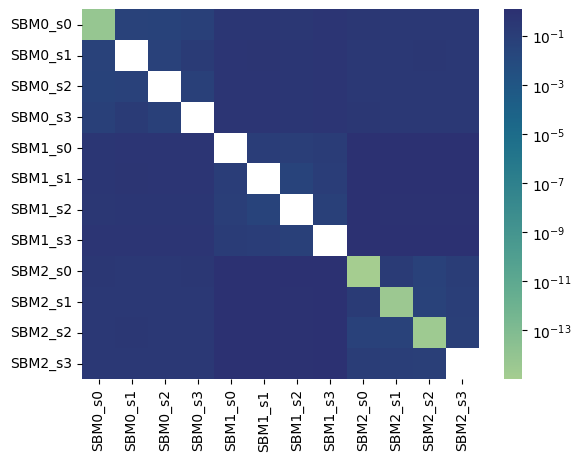

In [ ]:

sns.heatmap(dist,xticklabels=inner_W_dist_GMMs.keys(),yticklabels=inner_W_dist_GMMs.keys(),cmap="crest",norm=LogNorm(),vmax=1.,vmin= 10. ** -4)

/tmp/ipykernel_476129/598458581.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1)


/tmp/ipykernel_476129/598458581.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1)
/tmp/ipykernel_476129/598458581.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1)
/tmp/ipykernel_476129/598458581.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1)
/tmp/ipykernel_476129/598458581.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1)
/tmp/ipykernel_476129/598458581.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i,j] = GaussianW2(m0=m0,m1=m1,Sigma0=S0,Sigma1=S1)
/tmp/ipykernel_476129/598458581.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i,j] = GaussianW2(m

<Axes: >

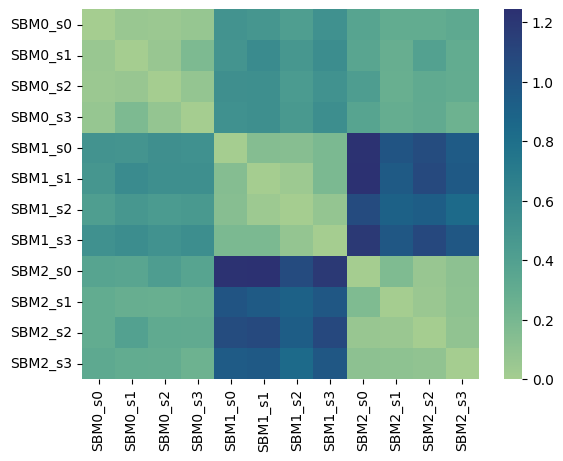

In [ ]:
inner_W_dist_GMMs_onlyShape = {}
for id, gmm in sampled_GMMs.items():
    inner_W_dist_GMMs_onlyShape[id] = inner_GMM__wasserstein_dist(gmm,pts=sampled_STR_pts[id],shape_only=True)

dist = np.zeros((len(sampled_GMMs),len(sampled_GMMs)))

for i,(dists1, gmm1) in enumerate(zip(inner_W_dist_GMMs_onlyShape.values() ,sampled_GMMs.values())):
    for j,(dists2, gmm2) in enumerate(zip(inner_W_dist_GMMs_onlyShape.values() ,sampled_GMMs.values())):
        w2, log = ot.gromov.gromov_wasserstein(
        C1=dists1, C2=dists2, p=gmm1.weights_, q=gmm2.weights_,loss_fun =  'square_loss', verbose=False, log=True)
        dist[i,j] = log['gw_dist']

sns.heatmap(dist,xticklabels=inner_W_dist_GMMs_onlyShape.keys(),yticklabels=inner_W_dist_GMMs_onlyShape.keys(),cmap="crest")